Dataset1

Import modułów

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import datasets, layers, models
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import random
import sklearn.model_selection
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import sklearn.model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

Załadowanie dataset1

In [2]:
def load_img(indir):
    samples = []
    labels = []
    for class_dir in os.listdir(indir):
        the_class = class_dir
        for file in os.listdir(indir+'/'+class_dir):
            image = cv2.imread("{}/{}/{}".format(indir,class_dir,file))
            #image = preprocess_input(image)
            image = cv2.resize(image, (64,64))
            samples.append(image)
            labels.append(the_class)
    samples = np.array(samples)
    labels = np.array(labels)
    return samples,labels
samples, labels = load_img('dataset1')
print('loaded',len(samples),' samples')
print('classes',set(labels))
org_samples = samples
org_labels = labels

loaded 657  samples
classes {'sunrise', 'cloudy'}


Pokazanie kilku losowych odczytanych obrazków

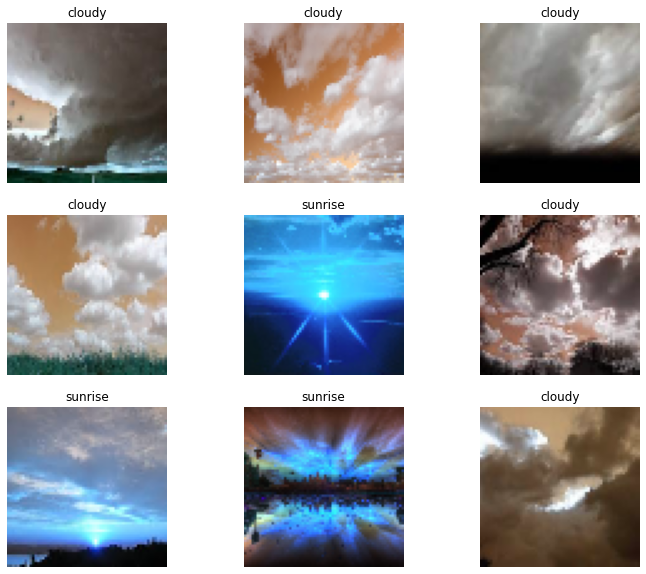

In [3]:
plt.figure(figsize=(12, 10))
for i in range(9):
    n = random.randrange(len(samples))
    plt.subplot(3, 3, i + 1)
    plt.imshow(samples[n])
    plt.title(labels[n])
    plt.axis("off")

Utworzenie modelu CNN

In [4]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0

Binraryzacja etykiet

In [5]:
# one-hot labels
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = np.hstack((labels, 1 - labels))
print("Labels shape",labels.shape)
labels = labels.astype(float)

Labels shape (657, 2)


Podział na zbiory treningowe, testowe i trenowanie modelu

In [6]:
#samples = org_samples
print(samples.shape)
(trainSamples, testSamples, trainLabels, testLabels) = sklearn.model_selection.train_test_split(samples,labels,random_state=42)
optimizer = tf.keras.optimizers.RMSprop(0.0001, decay = 1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])

(657, 64, 64, 3)


In [7]:
H = model.fit(trainSamples, trainLabels, epochs=10, validation_data=(testSamples,testLabels))  

Train on 492 samples, validate on 165 samples
Epoch 1/10
492/492 [==============================] - 2s 4ms/sample - loss: 11.0246 - accuracy: 0.6585 - val_loss: 1.5213 - val_accuracy: 0.8242
Epoch 2/10
492/492 [==============================] - 1s 3ms/sample - loss: 4.4446 - accuracy: 0.8008 - val_loss: 6.5307 - val_accuracy: 0.6000
Epoch 3/10
492/492 [==============================] - 1s 3ms/sample - loss: 3.8836 - accuracy: 0.8435 - val_loss: 0.6787 - val_accuracy: 0.9333
Epoch 4/10
492/492 [==============================] - 1s 3ms/sample - loss: 1.7667 - accuracy: 0.9065 - val_loss: 0.6282 - val_accuracy: 0.9515
Epoch 5/10
492/492 [==============================] - 1s 3ms/sample - loss: 2.1919 - accuracy: 0.8780 - val_loss: 0.8530 - val_accuracy: 0.9455
Epoch 6/10
492/492 [==============================] - 1s 3ms/sample - loss: 1.3203 - accuracy: 0.9187 - val_loss: 0.4360 - val_accuracy: 0.9697
Epoch 7/10
492/492 [==============================] - 1s 3ms/sample - loss: 1.2632 - accu

Wyniki

In [8]:
mlpResults = model.predict(testSamples)
print(confusion_matrix(testLabels.argmax(axis=1), mlpResults.argmax(axis=1)))
print(classification_report(testLabels.argmax(axis=1), mlpResults.argmax(axis=1),target_names=lb.classes_))
mlpAcc = accuracy_score(testLabels.argmax(axis=1), mlpResults.argmax(axis=1)) 
print("MLP Accuracy: {:.2f}".format(mlpAcc))

[[83  1]
 [ 1 80]]
              precision    recall  f1-score   support

      cloudy       0.99      0.99      0.99        84
     sunrise       0.99      0.99      0.99        81

    accuracy                           0.99       165
   macro avg       0.99      0.99      0.99       165
weighted avg       0.99      0.99      0.99       165

MLP Accuracy: 0.99


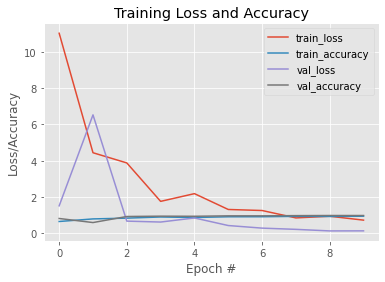

In [9]:
N = np.arange(0, 10)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["accuracy"], label="train_accuracy")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["val_accuracy"], label="val_accuracy")
    
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

Dataset1 + Dataset2

Załadowanie Dataset1 i Dataset2

In [10]:
def load_img():
    samples2 = []
    labels2 = []
    for class_dir in os.listdir('dataset1'):
        the_class = class_dir
        for file in os.listdir('dataset1'+'/'+class_dir):
            image = cv2.imread("{}/{}/{}".format('dataset1',class_dir,file))
            #image = preprocess_input(image)
            image = cv2.resize(image, (64,64))
            samples2.append(image)
            labels2.append(the_class)
    for class_dir in os.listdir('dataset2'):
        the_class = class_dir
        for file in os.listdir('dataset2'+'/'+class_dir):
            image = cv2.imread("{}/{}/{}".format('dataset2',class_dir,file))
            #image = preprocess_input(image)
            image = cv2.resize(image, (64,64))
            samples2.append(image)
            labels2.append(the_class)        
    samples2 = np.array(samples2)
    labels2 = np.array(labels2)
    return samples2,labels2
samples2, labels2 = load_img()
print('loaded',len(samples2),' samples')
print('classes',set(labels2))
org_samples2 = samples2
org_labels2 = labels2

loaded 1123  samples
classes {'sunrise', 'cloudy', 'rain', 'shine'}


Pokazanie kilku losowych obrazków

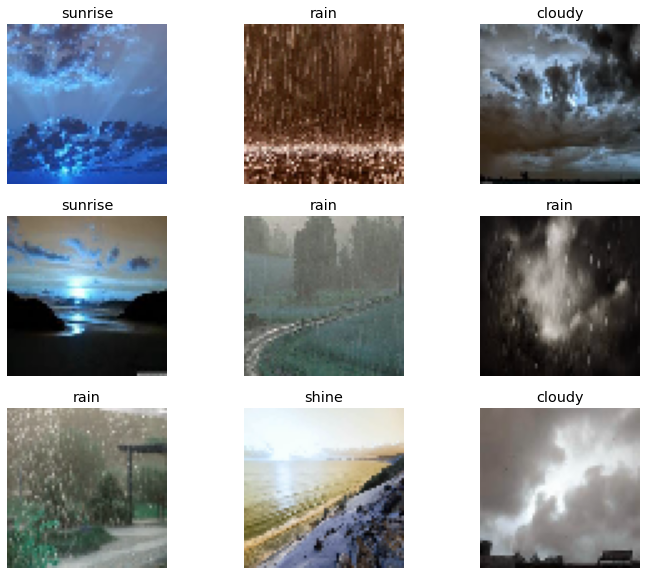

In [11]:
plt.figure(figsize=(12, 10))
for i in range(9):
    n = random.randrange(len(samples2))
    plt.subplot(3, 3, i + 1)
    plt.imshow(samples2[n])
    plt.title(labels2[n])
    plt.axis("off")

Binaryzacja label

In [12]:
# one-hot labels
lb = LabelBinarizer()
labels2 = lb.fit_transform(labels2)
print("Labels shape",labels2.shape)
labels2 = labels2.astype(float)

Labels shape (1123, 4)


Utworzenie modelu dla 4 zbiorów

In [13]:
model2 = Sequential()
model2.add(Conv2D(16, (3, 3), padding="same",input_shape=(64,64,3)))
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(32, (3, 3), padding="same"))
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(512))
model2.add(Activation("relu"))
model2.add(Dense(4))
model2.add(Activation("softmax"))

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 32)       

Trenowanie modelu

In [14]:
print(samples2.shape)
(trainSamples2, testSamples2, trainLabels2, testLabels2) = sklearn.model_selection.train_test_split(samples2,labels2,random_state=42)
optimizer = tf.keras.optimizers.RMSprop(0.0001, decay = 1e-6)
model2.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])

(1123, 64, 64, 3)


In [15]:
H2 = model2.fit(trainSamples2, trainLabels2, epochs=10, validation_data=(testSamples2,testLabels2))  

Train on 842 samples, validate on 281 samples
Epoch 1/10
842/842 [==============================] - 4s 4ms/sample - loss: 62.5927 - accuracy: 0.4477 - val_loss: 30.5404 - val_accuracy: 0.5374
Epoch 2/10
842/842 [==============================] - 3s 4ms/sample - loss: 17.1359 - accuracy: 0.5926 - val_loss: 16.9389 - val_accuracy: 0.4698
Epoch 3/10
842/842 [==============================] - 3s 4ms/sample - loss: 12.6545 - accuracy: 0.6437 - val_loss: 14.2081 - val_accuracy: 0.6406
Epoch 4/10
842/842 [==============================] - 3s 4ms/sample - loss: 9.3302 - accuracy: 0.6580 - val_loss: 9.0914 - val_accuracy: 0.5943
Epoch 5/10
842/842 [==============================] - 3s 4ms/sample - loss: 6.0458 - accuracy: 0.7114 - val_loss: 6.6340 - val_accuracy: 0.6584
Epoch 6/10
842/842 [==============================] - 3s 3ms/sample - loss: 4.7349 - accuracy: 0.7399 - val_loss: 2.6947 - val_accuracy: 0.7580
Epoch 7/10
842/842 [==============================] - 3s 4ms/sample - loss: 3.6551 -

Wyniki

In [16]:
mlpResults = model2.predict(testSamples2)
print(confusion_matrix(testLabels2.argmax(axis=1), mlpResults.argmax(axis=1)))
print(classification_report(testLabels2.argmax(axis=1), mlpResults.argmax(axis=1),target_names=lb.classes_))
mlpAcc = accuracy_score(testLabels2.argmax(axis=1), mlpResults.argmax(axis=1)) 
print("MLP Accuracy: {:.2f}".format(mlpAcc))

[[24 45 10  0]
 [ 0 56  0  0]
 [ 0  4 52  1]
 [ 1  4  2 82]]
              precision    recall  f1-score   support

      cloudy       0.96      0.30      0.46        79
        rain       0.51      1.00      0.68        56
       shine       0.81      0.91      0.86        57
     sunrise       0.99      0.92      0.95        89

    accuracy                           0.76       281
   macro avg       0.82      0.78      0.74       281
weighted avg       0.85      0.76      0.74       281

MLP Accuracy: 0.76


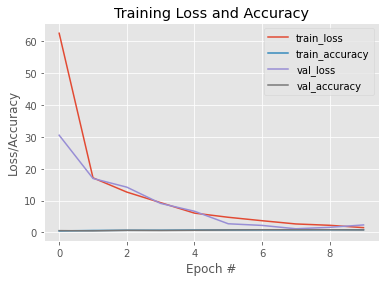

In [17]:
N = np.arange(0, 10)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H2.history["loss"], label="train_loss")
plt.plot(N, H2.history["accuracy"], label="train_accuracy")
plt.plot(N, H2.history["val_loss"], label="val_loss")
plt.plot(N, H2.history["val_accuracy"], label="val_accuracy")
    
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()